In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_ship_mon_Y_DN.csv",encoding="shift-jis",index_col=0)
df["ship_date"]

0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4195    2022-08-31
4196    2022-09-30
4197    2022-10-31
4198    2022-11-30
4199    2022-12-31
Name: ship_date, Length: 4200, dtype: object

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4195    0
4196    0
4197    0
4198    0
4199    0
Name: mon_1, Length: 4200, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [5]:
# change to the datetime format
df['ship_date'] = pd.to_datetime(df["ship_date"], format='%Y-%m-%d')
df=df.set_index(["id","ship_date"])
# df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2867 entries, (114, Timestamp('2009-02-28 00:00:00')) to (799, Timestamp('2022-12-31 00:00:00'))
Columns: 117 entries, year to year_trend
dtypes: float64(14), int32(3), int64(79), object(9), uint8(12)
memory usage: 2.3+ MB


(117, 167, 19)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

elapsed dummies


In [7]:
before_p=10
after_p=15
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)

+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15


## RX

                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
elapsed_m10         -0.1011     0.1038    -0.9742     0.3300     -0.3045      0.1024
elapsed_m9          -0.0548     0.0721    -0.7601     0.4473     -0.1963      0.0866
elapsed_m8           0.0256     0.0731     0.3501     0.7263     -0.1177      0.1689
elapsed_m7           0.0230     0.0631     0.3637     0.7161     -0.1008      0.1468
elapsed_m6           0.1644     0.0650     2.5296     0.0115      0.0370      0.2918
elapsed_m5           0.0290     0.0523     0.5549     0.5790     -0.0736      0.1317
elapsed_m4           0.0480     0.0588     0.8165     0.4143     -0.0673      0.1633
elapsed_m3          -0.0270     0.0441    -0.6114     0.5410     -0.1134      0.0595
elapsed_m2           0.0054     0.0456     0.1185     0.9057     

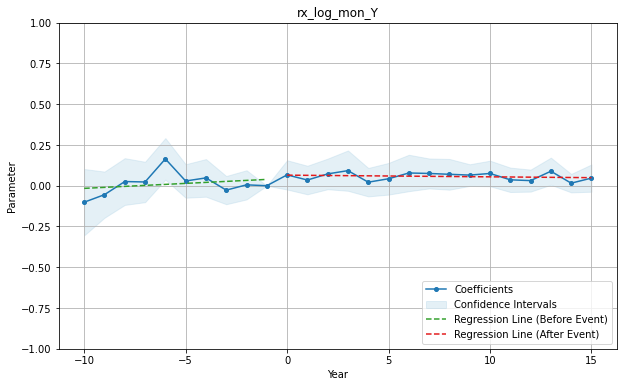

In [8]:
# take log
formula="log_rx_dom ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_Y",title="rx_log_mon_Y",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
elapsed_m10           0.0979     0.1477     0.6633     0.5072     -0.1916      0.3875
elapsed_m9            0.2421     0.2082     1.1626     0.2451     -0.1662      0.6504
elapsed_m8            0.1282     0.2206     0.5814     0.5610     -0.3043      0.5608
elapsed_m7           -0.2939     0.2349    -1.2512     0.2110     -0.7544      0.1667
elapsed_m6           -0.1019     0.1302    -0.7825     0.4340     -0.3571      0.1534
elapsed_m5            0.0665     0.1572     0.4234     0.6721     -0.2417      0.3748
elapsed_m4            0.0630     0.1690     0.3726     0.7095     -0.2685      0.3944
elapsed_m3            0.2049     0.1933     1.0600     0.2893     -0.1741      0.5838
elapsed_m2            0.2614     0.1538     1.7001    

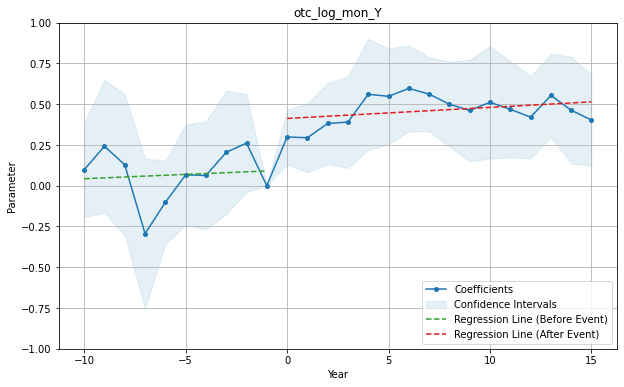

In [9]:
# take log

# till 20
# formula="log_otc_dom ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_dom ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_otc_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_Y",title="otc_log_mon_Y",ylim=(-1,1),plot_type="-o",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)